In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd

# ✅ Set your GraphDB SPARQL endpoint
sparql_endpoint = "http://MacBookAir.modem:7200/repositories/ESGDataset"

def query_esg_data_by_topic(topic_keyword, industry_name):
    sparql = SPARQLWrapper(sparql_endpoint)
    
    # 🔍 Build the SPARQL query
    query = f"""
    PREFIX ex: <http://example.org/esg/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

    SELECT ?company ?year ?metric ?value ?category ?industry
    WHERE {{
      ?obs a ex:ESGObservation ;
           ex:hasCompany ?company ;
           ex:hasYear ?year ;
           ex:hasMetric ?metric ;
           ex:hasCategory ?category ;
           ex:hasIndustry ?industry ;
           ex:hasValue ?value .

      FILTER(CONTAINS(LCASE(STR(?category)), "{topic_keyword.lower()}"))
      FILTER(CONTAINS(LCASE(STR(?industry)), "{industry_name.lower()}"))
    }}
    """

    print("📤 Running SPARQL query:\n", query)
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    try:
        results = sparql.query().convert()
        print("✅ Query executed successfully.")
    except Exception as e:
        print("❌ Failed to execute query:", str(e))
        return pd.DataFrame()

    # 🧪 Check raw response
    print("🔄 Raw SPARQL response:")
    print(results)

    # 📊 Flatten into DataFrame
    rows = []
    for result in results["results"]["bindings"]:
        try:
            row = {
                "company": result["company"]["value"].split("/")[-1],
                "year": int(result["year"]["value"]),
                "metric": result["metric"]["value"].split("/")[-1],
                "value": float(result["value"]["value"]),
                "category": result["category"]["value"].split("/")[-1],
                "industry": result["industry"]["value"].split("/")[-1],
            }
            rows.append(row)
        except Exception as e:
            print("⚠️ Error processing result row:", e)
            print(result)

    df = pd.DataFrame(rows)
    print(f"📦 DataFrame shape: {df.shape}")
    return df
    return pd.DataFrame(rows)

In [ ]:
df_test = query_esg_data_by_topic("water", "biotechnology")
print(df_test.head())
print(df_test.columns)

In [4]:
df_wide = df_test.pivot_table(
    index=["company", "year"],
    columns="metric",
    values="value"
).reset_index()

print(df_wide.head())

metric                         company  year  WATER_USE_PAI_M10
0       Company_180_Life_Sciences_Corp  2021                0.0
1       Company_180_Life_Sciences_Corp  2022                0.0
2       Company_180_Life_Sciences_Corp  2023                0.0
3       Company_180_Life_Sciences_Corp  2024                0.0
4          Company_1933_Industries_Inc  2021                0.0


In [5]:
print(df_test.shape)              # Should have > 30–50 rows ideally
print(df_wide.shape)              # Enough company-year rows & metrics
print(df_wide.isnull().sum())     # Check missing values per metric

(10452, 6)
(10452, 3)
metric
company              0
year                 0
WATER_USE_PAI_M10    0
dtype: int64


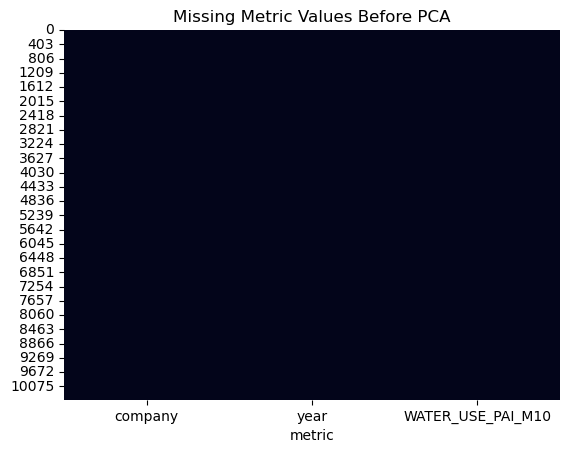

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_wide.isnull(), cbar=False)
plt.title("Missing Metric Values Before PCA")
plt.show()

In [8]:
df_ghg = query_esg_data_by_topic("co2", "biotechnology")

📤 Running SPARQL query:
 
    PREFIX ex: <http://example.org/esg/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

    SELECT ?company ?year ?metric ?value ?category ?industry
    WHERE {
      ?obs a ex:ESGObservation ;
           ex:hasCompany ?company ;
           ex:hasYear ?year ;
           ex:hasMetric ?metric ;
           ex:hasCategory ?category ;
           ex:hasIndustry ?industry ;
           ex:hasValue ?value .

      FILTER(CONTAINS(LCASE(STR(?category)), "co2"))
      FILTER(CONTAINS(LCASE(STR(?industry)), "biotechnology"))
    }
    
✅ Query executed successfully.
🔄 Raw SPARQL response:
{'head': {'vars': ['company', 'year', 'metric', 'value', 'category', 'industry']}, 'results': {'bindings': []}}
📦 DataFrame shape: (0, 0)


In [10]:
def query_by_metric_keyword(metric_keyword, industry_name):
    sparql = SPARQLWrapper(sparql_endpoint)
    query = f"""
    PREFIX ex: <http://example.org/esg/>
    SELECT ?company ?year ?metric ?value ?industry
    WHERE {{
      ?obs a ex:ESGObservation ;
           ex:hasCompany ?company ;
           ex:hasYear ?year ;
           ex:hasMetric ?metric ;
           ex:hasIndustry ?industry ;
           ex:hasValue ?value .

      FILTER(CONTAINS(LCASE(STR(?metric)), "{metric_keyword.lower()}"))
      FILTER(CONTAINS(LCASE(STR(?industry)), "{industry_name.lower()}"))
    }}
    """
    print("📤 Running SPARQL query:\n", query)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    rows = []
    for result in results["results"]["bindings"]:
        row = {
            "company": result["company"]["value"].split("/")[-1],
            "year": int(result["year"]["value"]),
            "metric": result["metric"]["value"].split("/")[-1],
            "value": float(result["value"]["value"]),
            "industry": result["industry"]["value"].split("/")[-1],
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    print(f"📦 DataFrame shape: {df.shape}")
    return df

In [11]:
df_co2 = query_by_metric_keyword("co2", "biotechnology")

📤 Running SPARQL query:
 
    PREFIX ex: <http://example.org/esg/>
    SELECT ?company ?year ?metric ?value ?industry
    WHERE {
      ?obs a ex:ESGObservation ;
           ex:hasCompany ?company ;
           ex:hasYear ?year ;
           ex:hasMetric ?metric ;
           ex:hasIndustry ?industry ;
           ex:hasValue ?value .

      FILTER(CONTAINS(LCASE(STR(?metric)), "co2"))
      FILTER(CONTAINS(LCASE(STR(?industry)), "biotechnology"))
    }
    
📦 DataFrame shape: (52690, 5)


In [12]:
print(df_co2.head())
print(df_co2["metric"].value_counts())

                       company  year             metric    value  \
0  Company_1933_Industries_Inc  2017    CO2DIRECTSCOPE1   107.62   
1  Company_1933_Industries_Inc  2017  CO2INDIRECTSCOPE2   133.74   
2  Company_1933_Industries_Inc  2018    CO2DIRECTSCOPE1   995.11   
3  Company_1933_Industries_Inc  2018  CO2INDIRECTSCOPE2   359.37   
4  Company_1933_Industries_Inc  2018  CO2INDIRECTSCOPE3  2336.77   

                                     industry  
0  Industry_Biotechnology_and_Pharmaceuticals  
1  Industry_Biotechnology_and_Pharmaceuticals  
2  Industry_Biotechnology_and_Pharmaceuticals  
3  Industry_Biotechnology_and_Pharmaceuticals  
4  Industry_Biotechnology_and_Pharmaceuticals  
metric
CO2DIRECTSCOPE1      22234
CO2INDIRECTSCOPE2    20606
CO2INDIRECTSCOPE3     9850
Name: count, dtype: int64


In [13]:
df_wide_co2 = df_co2.pivot_table(
    index=["company", "year"],
    columns="metric",
    values="value"
).reset_index()

print(df_wide_co2.head())

metric                      company  year  CO2DIRECTSCOPE1  CO2INDIRECTSCOPE2  \
0       Company_1933_Industries_Inc  2017        53.817640          66.879494   
1       Company_1933_Industries_Inc  2018       497.625642         179.710511   
2       Company_1933_Industries_Inc  2019       433.866591         152.361629   
3       Company_1933_Industries_Inc  2020       455.849711         143.205329   
4       Company_1933_Industries_Inc  2021       401.997067         105.404963   

metric  CO2INDIRECTSCOPE3  
0                     NaN  
1             1168.550885  
2             1257.318486  
3             1285.582499  
4             1315.671770  


In [14]:
df_filled_co2 = df_wide_co2.fillna(df_wide_co2.mean(numeric_only=True))